In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,load_model
import cupy as cp
from keras.layers import LSTM
from  tensorflow.keras.layers import LSTM,Dense,Activation,Dropout
from  tensorflow.keras.callbacks import History,Callback,EarlyStopping
import os
import tensorflow as tf
import datetime
import h5py

In [ ]:
f = h5py.File('D:/library/Github/Innovative-practice/library/csv/第三学期/trainX.h5', 'r')
trainX = f['data']
trainX  = cp.array(trainX)
f.close()
f = h5py.File('D:/library/Github/Innovative-practice/library/csv/第三学期/trainY.h5', 'r')
trainY = f['data']
trainY  = cp.array(trainY)
f.close()
f = h5py.File('D:/library/Github/Innovative-practice/library/csv/第三学期/testX.h5', 'r')
testX = f['data']
testX  = cp.array(testX)
f.close()
f = h5py.File('D:/library/Github/Innovative-practice/library/csv/第三学期/testY.h5', 'r')
testY = f['data']
testY  = cp.array(testY)
f.close()
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

In [ ]:
#选择要测试kpi sms=0 call=1 internet=2
kpi=2
if kpi==0:
    kpi_name='sms'
elif kpi==1:
    kpi_name='call'
else:
    kpi_name='internet'

In [ ]:
#归一化
print(cp.max(trainY[:,2]))
print(cp.max(trainY[:,3]))
print(cp.max(trainY[:,4]))
if kpi==0:
    max_data=cp.max(testlist[:,2]).get()
elif kpi==1:
    max_data=cp.max(testlist[:,3]).get()
else:
    max_data=cp.max(testlist[:,4]).get()
#max_data的类型
print(type(max_data))
for i in range(3):
    trainlist[:,i+2] = trainlist[:,i+2]/cp.max(trainlist[:,i+2])
    testlist[:,i+2] = testlist[:,i+2]/cp.max(testlist[:,i+2])

In [ ]:
model = Sequential()
model.add(LSTM(80,input_shape=(trainX.shape[1],trainX.shape[2]),
                   return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(80,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(trainY.shape[1]))
model.add(Activation("relu"))

model.summary()

In [ ]:


cbs = [History(), EarlyStopping(monitor='val_loss',
                                patience=10,
                                min_delta=0.00001,
                                verbose=0)]
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+kpi_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history=model.fit(trainX.get(),
        trainY.get(),
        batch_size=64,
        epochs=200,
        validation_split=0.2,
        callbacks=[cbs,tensorboard_callback],
        verbose=True)
model.save(os.path.join(f"D:\library\Github\Innovative-practice\第三学期\DATA\lstm",f"Test_{kpi_name}" + ".h5"))

In [ ]:
%tensorboard --logdir D:/downloads/logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
model = load_model(os.path.join(f"D:\library\Github\Innovative-practice\第三学期\DATA\lstm",f"Test_{kpi_name}" + ".h5"))
trainPredict = model.predict(trainX.get())
testPredict = model.predict(testX[:].get())

print(trainPredict.shape)
print(testPredict.shape)



931/931 [==============================] - 3s 3ms/step
(118974, 1)
(29774, 1)


In [ ]:
testPredict = testPredict
testY = testY.get()

In [ ]:
#testY和testPredict的差值的绝对值
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
print(testY[0,:])
print(testPredict[0,:])

plt.figure( figsize=(100,10) )
plt.plot(abs(testY[:]-testPredict))
plt.title(f"{kpi_name}测试集误差图",fontsize=100)
plt.savefig(f'D:\library\Github\Innovative-practice\第三学期\DATA\pic\lstm\{kpi_name}测试集误差图.png')
plt.show()

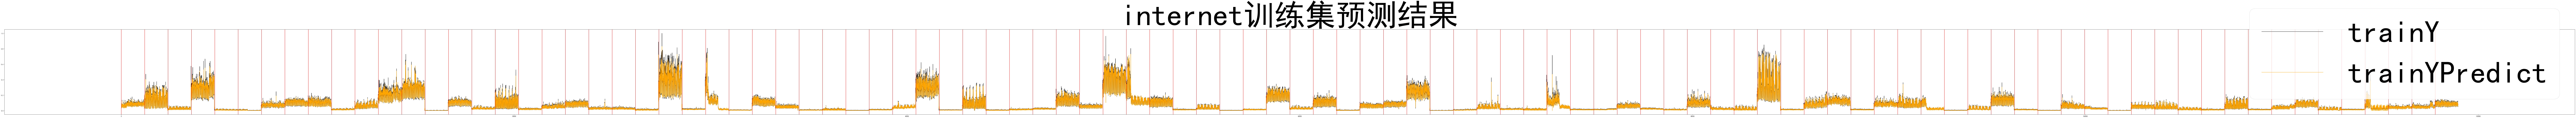

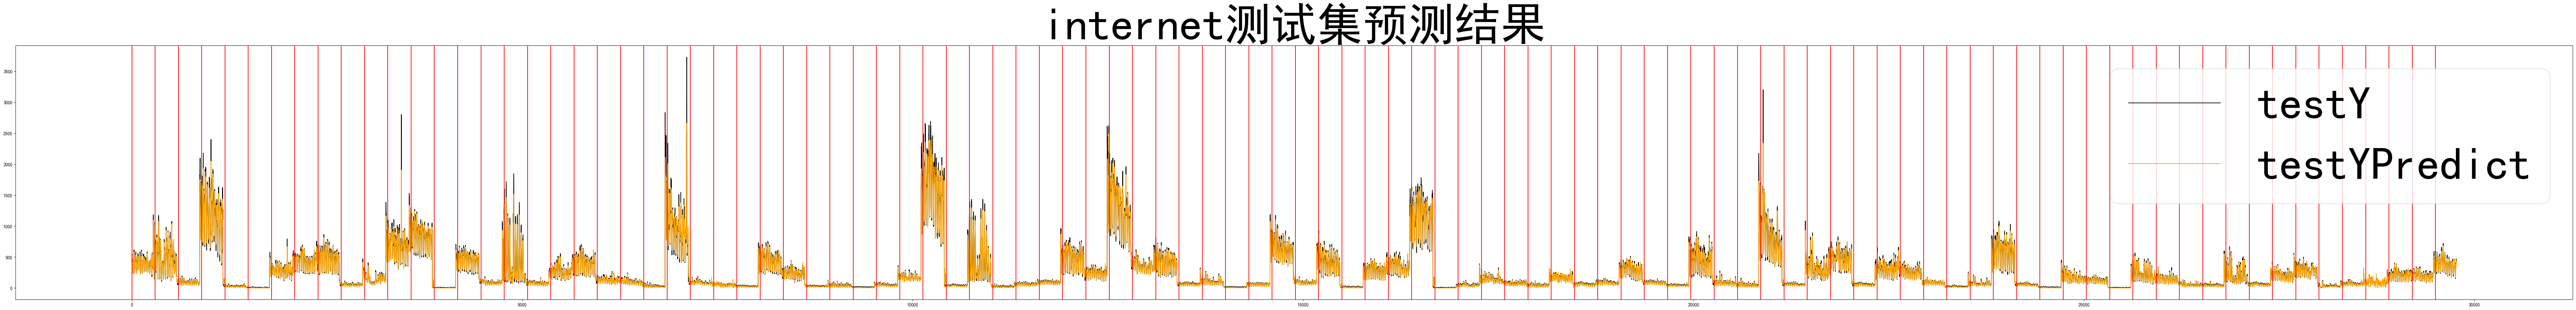

In [ ]:
import matplotlib.pyplot as plt
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure( figsize=(300,10) )
plt.plot(trainY.get(),color="black")
plt.plot(trainPredict[1:],color="orange")
plt.legend(['trainY',"trainYPredict"],fontsize=200)
#绘制100条竖线
for i in range(100):
    plt.axvline(i*1190,color="red")


plt.title(f"{kpi_name}训练集预测结果",fontsize=200)
plt.savefig(f'D:\library\Github\Innovative-practice\第三学期\DATA\pic\lstm\{kpi_name}训练集预测结果.png')
plt.show()

plt.figure( figsize=(100,10) )
plt.plot(testY[:]*max_data,color="black")
plt.plot(testPredict[1:]*max_data,color="orange")
plt.legend(['testY',"testYPredict"],fontsize=100)
for i in range(100):
    plt.axvline(i*298,color="red")
plt.title(f"{kpi_name}测试集预测结果",fontsize=100)
plt.savefig(f'D:\library\Github\Innovative-practice\第三学期\DATA\pic\lstm\{kpi_name}测试集预测结果.png')
plt.show()

In [ ]:
from  sklearn import  metrics
import numpy as np

def GetRMSE(y_hat,y_test):
    sum = np.sqrt(metrics.mean_squared_error(y_test, y_hat))
    return  sum

def GetMAE(y_hat,y_test):
    sum = metrics.mean_absolute_error(y_test, y_hat)
    return  sum

def GetMAPE(y_hat,y_test):
    sum = np.mean(np.abs((y_hat - y_test) / y_test)) * 100
    return sum

def GetMAPE_Order(y_hat,y_test):
    #删除test_y 为0元素
    zero_index = np.where(y_test == 0)
    y_hat = np.delete(y_hat,zero_index[0])
    y_test = np.delete(y_test,zero_index[0])
    sum = np.mean(np.abs((y_hat - y_test) / y_test)) * 100
    return sum
#计算R2
def GetR2(y_hat,y_test):
    sum = metrics.r2_score(y_test, y_hat)
    return sum
print(type(testY))
testY=testY*max_data
testPredict=testPredict*max_data


print("RMSE为", GetRMSE(testY[:], testPredict[:]))
print("MAE为", GetMAE(testY[:], testPredict[:]))
print("MAPE为", GetMAPE_Order(testY[:], testPredict[:]))
print("R2为", GetR2(testY[:], testPredict[:]))


<class 'numpy.ndarray'>
RMSE为 68.13477021191792
MAE为 29.114336655058686
MAPE为 56.392675330649666
R2为 0.9563368749479582
